# Acknowledgement


Experimental Book

Objective: Create a realtime inference model to classify garbage based on its type.

Milestones:
- Model a high performing heavy neural network classifier and save its parameters (Model A: ResNet50)
- Model an lightweight mobile-based model for realtime inferencing (Model B: MobileNet)
- Experiment and evaluate the lightweight model in realtime inferencing
- Start new model based on the same architecture (Model C) with having Model A's weight as knowledge distillation to Model C
- Comparative Analysis between Model B and Model C with:
  - Model Performance
  - Benchmarking (e.g. latency, memory footprint)

## Authors
Ananda Risyad - ananda.risyad@binus.ac.id

Lawrance Cancerlon - lawrance.cancerlon@binus.ac.id

Bryan Wu - bryan.wu@binus.ac.id

Yonathan Henry Christianto - yonathan.christianto@binus.ac.id

Ruby Belinda Gunadi - ruby.gunadi@binus.ac.id

# Scratch Book 1

## Imports

In [14]:
import kagglehub
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as T
import csv
import os
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Constants

In [2]:
DATA_TRAIN = 0.8
DATA_TEST = 0.1
DATA_VALIDATION = 0.1

## Loading

In [3]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

Using Colab cache for faster access to the 'garbage-classification' dataset.


In [4]:
!mv /kaggle/input/garbage-classification/Garbage\ classification/ ./

mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal375.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal341.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal374.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal383.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal215.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal113.jpg': Read-only file system
mv: cannot remove '/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal213.jpg': Read-on

In [5]:
DATA_DIR = "./Garbage classification/Garbage classification/"

In [6]:
classes = os.listdir(DATA_DIR)
print(classes)

['plastic', 'paper', 'trash', 'glass', 'metal', 'cardboard']


## Process Dataset

In [7]:
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [8]:

class GarbageDataset(Dataset):
  def __init__(self, root_dir, extensions=('.jpg', '.jpeg', '.png'), train = False):
    self.items = []
    self.root_dir = root_dir
    self.extensions = extensions

    self.classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
    self.class_to_index = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    for cls in self.classes:
      cls_dir = os.path.join(root_dir, cls)
      for root, _, files in os.walk(cls_dir):
        for file in files:
          if file.lower().endswith(self.extensions):
            self.items.append((os.path.join(root, file), self.class_to_index[cls]))
    if not self.items:
      raise RuntimeError('No images found')

    self.preprocess_fn = preprocess

  def __getitem__(self, idx):
    path,label = self.items[idx]
    img = Image.open(path).convert('RGB')

    img = self.preprocess_fn(img)

    return img, label

  def __len__(self):
    return len(self.items)

  def getLabels(self):
    return self.classes

In [9]:
from torch.utils.data import random_split, DataLoader, Subset
full_dataset = GarbageDataset(DATA_DIR)

classes = full_dataset.getLabels()


total_size = len(full_dataset)
train_size = int(DATA_TRAIN * total_size)
val_size = int(DATA_VALIDATION * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

train_ds = GarbageDataset(DATA_DIR, train=True)
train_ds.items = [full_dataset.items[i] for i in train_subset.indices]


val_ds = GarbageDataset(DATA_DIR)
val_ds.items = [full_dataset.items[i] for i in val_subset.indices]

test_ds = GarbageDataset(DATA_DIR)
test_ds.items = [full_dataset.items[i] for i in test_subset.indices]


train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Dataset split into: Train ({len(train_ds)}), Validation ({len(val_ds)}), Test ({len(test_ds)})")
print(classes)

Dataset split into: Train (2021), Validation (252), Test (254)
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Modeling

In [19]:
num_classes = len(classes)
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)

train_labels = [item[1] for item in train_ds.items]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(resnet50.parameters(), lr=0.0001)

num_epochs = 50
patience = 5
best_val_acc = 0
epochs_no_improvement = 0
early_stop = False

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    resnet50.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_epoch = running_loss / len(train_dl)
    train_acc_epoch = 100 * correct_train / total_train
    train_losses.append(train_loss_epoch)
    train_accs.append(train_acc_epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss_epoch}, Accuracy: {train_acc_epoch}%")

    resnet50.eval()
    correct_val = 0
    total_val = 0
    val_loss_epoch = 0.0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_epoch /= len(val_dl)
    val_acc_epoch = 100 * correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accs.append(val_acc_epoch)

    print(f"Validation Loss: {val_loss_epoch}, Validation Accuracy: {val_acc_epoch}%")

    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        epochs_no_improvement = 0
        torch.save(resnet50.state_dict(), 'best_model.pth')
    else:
        epochs_no_improvement += 1
        if epochs_no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

resnet50.load_state_dict(torch.load('best_model.pth'))


Epoch 1/50, Loss: 1.1059490307234228, Accuracy: 67.73874319643741%
Validation Loss: 0.45192309468984604, Validation Accuracy: 86.11111111111111%
Epoch 2/50, Loss: 0.2616015219828114, Accuracy: 92.33052944087086%
Validation Loss: 0.19578913552686572, Validation Accuracy: 93.25396825396825%
Epoch 3/50, Loss: 0.10436448345717508, Accuracy: 98.07026224641267%
Validation Loss: 0.18255740427412093, Validation Accuracy: 93.65079365079364%
Epoch 4/50, Loss: 0.08652218592760619, Accuracy: 98.56506679861455%
Validation Loss: 0.22460378124378622, Validation Accuracy: 91.26984126984127%
Epoch 5/50, Loss: 0.06311113541596569, Accuracy: 98.02078179119248%
Validation Loss: 0.21701766131445765, Validation Accuracy: 92.46031746031746%
Epoch 6/50, Loss: 0.03573177167709218, Accuracy: 99.10935180603661%
Validation Loss: 0.19059014867525548, Validation Accuracy: 94.44444444444444%
Epoch 7/50, Loss: 0.03270657068787841, Accuracy: 99.208312716477%
Validation Loss: 0.1819801436504349, Validation Accuracy: 93

<All keys matched successfully>

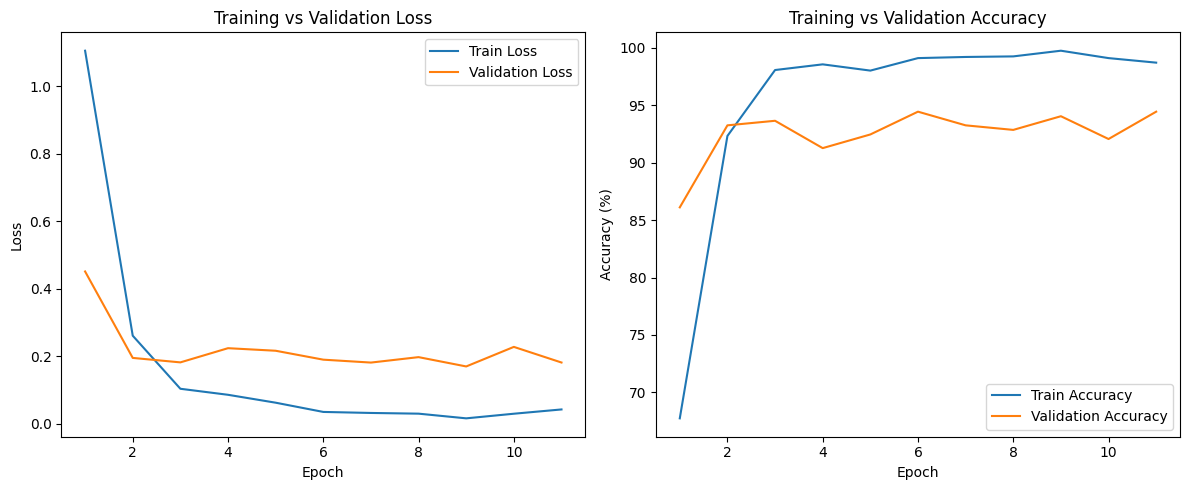

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
resnet50.eval()

all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

print(classification_report(all_labels, all_predicted, target_names=classes))

              precision    recall  f1-score   support

   cardboard       0.97      0.97      0.97        32
       glass       0.93      0.95      0.94        57
       metal       0.90      0.91      0.91        47
       paper       0.98      0.91      0.95        57
     plastic       0.91      0.95      0.93        43
       trash       0.83      0.83      0.83        18

    accuracy                           0.93       254
   macro avg       0.92      0.92      0.92       254
weighted avg       0.93      0.93      0.93       254



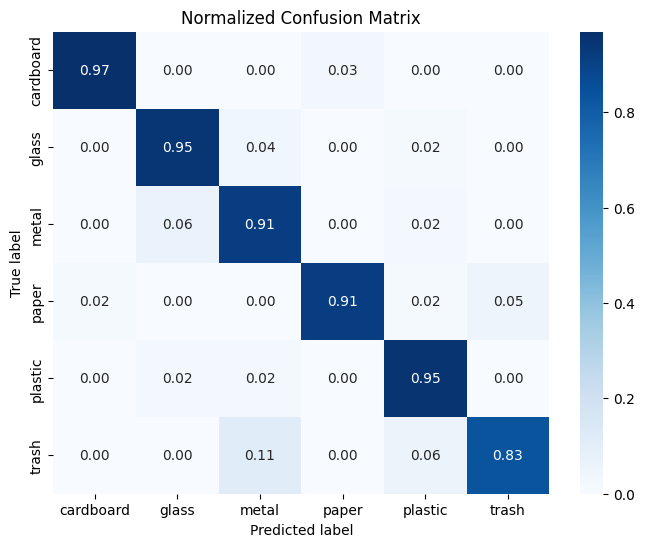

In [24]:
cm = confusion_matrix(all_labels, all_predicted)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Normalized Confusion Matrix')
plt.show()

In [25]:
!cp ./best_model.pth ./drive/MyDrive/trash_classifier_resnet50.pth

# Scratch Book 2

Experiment on MobileNet modeling

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

## Constants

In [27]:
DATA_TRAIN = 0.8
DATA_TEST = 0.1
DATA_VALIDATION = 0.1

In [28]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

Using Colab cache for faster access to the 'garbage-classification' dataset.


In [29]:
DATA_DIR = "./Garbage classification/Garbage classification/"

In [30]:
classes = os.listdir(DATA_DIR)
print(classes)

['plastic', 'paper', 'trash', 'glass', 'metal', 'cardboard']


## Preprocess Data

In [31]:
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [32]:

class GarbageDataset(Dataset):
  def __init__(self, root_dir, extensions=('.jpg', '.jpeg', '.png'), train = False):
    self.items = []
    self.root_dir = root_dir
    self.extensions = extensions

    self.classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
    self.class_to_index = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    for cls in self.classes:
      cls_dir = os.path.join(root_dir, cls)
      for root, _, files in os.walk(cls_dir):
        for file in files:
          if file.lower().endswith(self.extensions):
            self.items.append((os.path.join(root, file), self.class_to_index[cls]))
    if not self.items:
      raise RuntimeError('No images found')

    self.preprocess_fn = preprocess

  def __getitem__(self, idx):
    path,label = self.items[idx]
    img = Image.open(path).convert('RGB')

    img = self.preprocess_fn(img)

    return img, label

  def __len__(self):
    return len(self.items)

  def getLabels(self):
    return self.classes

In [33]:
from torch.utils.data import random_split, DataLoader, Subset
full_dataset = GarbageDataset(DATA_DIR)

classes = full_dataset.getLabels()


total_size = len(full_dataset)
train_size = int(DATA_TRAIN * total_size)
val_size = int(DATA_VALIDATION * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

train_ds = GarbageDataset(DATA_DIR, train=True)
train_ds.items = [full_dataset.items[i] for i in train_subset.indices]


val_ds = GarbageDataset(DATA_DIR)
val_ds.items = [full_dataset.items[i] for i in val_subset.indices]

test_ds = GarbageDataset(DATA_DIR)
test_ds.items = [full_dataset.items[i] for i in test_subset.indices]


train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Dataset split into: Train ({len(train_ds)}), Validation ({len(val_ds)}), Test ({len(test_ds)})")
print(classes)

Dataset split into: Train (2021), Validation (252), Test (254)
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Modeling

In [34]:
num_classes = len(classes)

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet.to(device)

train_labels = [item[1] for item in train_ds.items]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(mobilenet.parameters(), lr=1e-4)

num_epochs = 50
patience = 5
best_val_acc = 0
epochs_no_improvement = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 59.5MB/s]


In [35]:

for epoch in range(num_epochs):
    mobilenet.train()
    running_loss, correct_train, total_train = 0.0, 0, 0
    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_epoch = running_loss / len(train_dl)
    train_acc_epoch = 100 * correct_train / total_train
    train_losses.append(train_loss_epoch)
    train_accs.append(train_acc_epoch)

    mobilenet.eval()
    val_loss_epoch, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_epoch /= len(val_dl)
    val_acc_epoch = 100 * correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accs.append(val_acc_epoch)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_epoch:.4f}, Train Acc: {train_acc_epoch:.2f}% | Val Loss: {val_loss_epoch:.4f}, Val Acc: {val_acc_epoch:.2f}%")

    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        epochs_no_improvement = 0
        torch.save(mobilenet.state_dict(), 'best_mobilenet.pth')
    else:
        epochs_no_improvement += 1
        if epochs_no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

mobilenet.load_state_dict(torch.load('best_mobilenet.pth'))
mobilenet.eval()

Epoch 1/50 - Train Loss: 1.3984, Train Acc: 60.56% | Val Loss: 0.9503, Val Acc: 76.19%
Epoch 2/50 - Train Loss: 0.6909, Train Acc: 82.14% | Val Loss: 0.5878, Val Acc: 82.14%
Epoch 3/50 - Train Loss: 0.3811, Train Acc: 89.21% | Val Loss: 0.4308, Val Acc: 85.32%
Epoch 4/50 - Train Loss: 0.2213, Train Acc: 94.41% | Val Loss: 0.4192, Val Acc: 87.30%
Epoch 5/50 - Train Loss: 0.1340, Train Acc: 97.28% | Val Loss: 0.3874, Val Acc: 86.90%
Epoch 6/50 - Train Loss: 0.0979, Train Acc: 97.97% | Val Loss: 0.3847, Val Acc: 86.51%
Epoch 7/50 - Train Loss: 0.0813, Train Acc: 98.61% | Val Loss: 0.4036, Val Acc: 87.30%
Epoch 8/50 - Train Loss: 0.0552, Train Acc: 99.21% | Val Loss: 0.3892, Val Acc: 88.89%
Epoch 9/50 - Train Loss: 0.0542, Train Acc: 98.76% | Val Loss: 0.3947, Val Acc: 88.49%
Epoch 10/50 - Train Loss: 0.0422, Train Acc: 99.26% | Val Loss: 0.4073, Val Acc: 87.30%
Epoch 11/50 - Train Loss: 0.0291, Train Acc: 99.60% | Val Loss: 0.3888, Val Acc: 89.68%
Epoch 12/50 - Train Loss: 0.0392, Train A

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

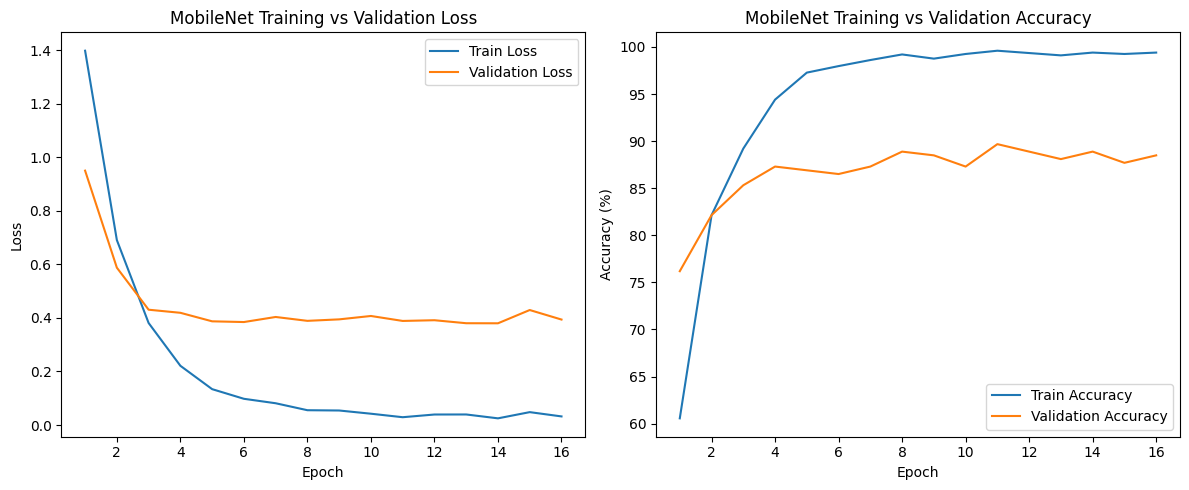

In [36]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MobileNet Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('MobileNet Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
mobilenet.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

              precision    recall  f1-score   support

   cardboard       0.97      1.00      0.98        32
       glass       0.94      0.85      0.89        54
       metal       0.88      0.94      0.91        49
       paper       0.94      0.88      0.91        51
     plastic       0.84      0.91      0.88        47
       trash       0.74      0.74      0.74        19

    accuracy                           0.90       252
   macro avg       0.89      0.89      0.89       252
weighted avg       0.90      0.90      0.90       252



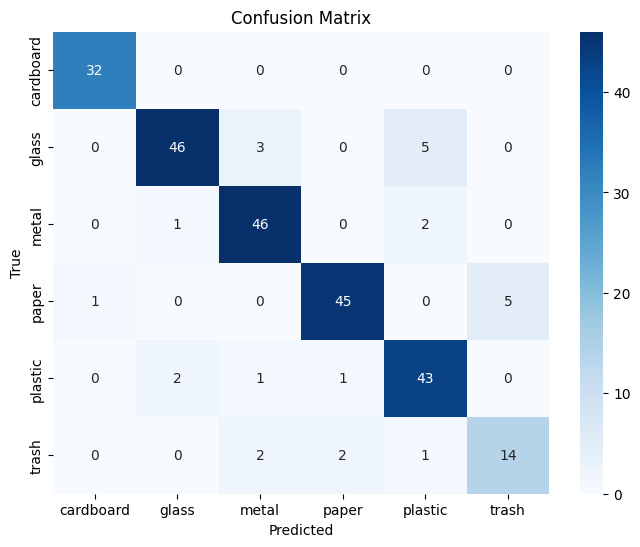

In [39]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Scratch Book 3

In [2]:
import kagglehub
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import torch
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torchvision.transforms as T
import csv
import os
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


## Constants

In [14]:
DATA_TRAIN = 0.8
DATA_TEST = 0.1
DATA_VALIDATION = 0.1

In [3]:
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

Using Colab cache for faster access to the 'garbage-classification' dataset.


In [6]:
print(path)

/kaggle/input/garbage-classification


In [9]:
DATA_DIR = path + "/Garbage classification/Garbage classification/"

In [10]:
classes = os.listdir(DATA_DIR)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


## Preprocess Data

In [12]:
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
class GarbageDataset(Dataset):
  def __init__(self, root_dir, extensions=('.jpg', '.jpeg', '.png'), train = False):
    self.items = []
    self.root_dir = root_dir
    self.extensions = extensions

    self.classes = sorted(entry.name for entry in os.scandir(root_dir) if entry.is_dir())
    self.class_to_index = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    for cls in self.classes:
      cls_dir = os.path.join(root_dir, cls)
      for root, _, files in os.walk(cls_dir):
        for file in files:
          if file.lower().endswith(self.extensions):
            self.items.append((os.path.join(root, file), self.class_to_index[cls]))
    if not self.items:
      raise RuntimeError('No images found')

    self.preprocess_fn = preprocess

  def __getitem__(self, idx):
    path,label = self.items[idx]
    img = Image.open(path).convert('RGB')

    img = self.preprocess_fn(img)

    return img, label

  def __len__(self):
    return len(self.items)

  def getLabels(self):
    return self.classes

In [16]:
from torch.utils.data import random_split, DataLoader, Subset
full_dataset = GarbageDataset(DATA_DIR)

classes = full_dataset.getLabels()


total_size = len(full_dataset)
train_size = int(DATA_TRAIN * total_size)
val_size = int(DATA_VALIDATION * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

train_ds = GarbageDataset(DATA_DIR, train=True)
train_ds.items = [full_dataset.items[i] for i in train_subset.indices]


val_ds = GarbageDataset(DATA_DIR)
val_ds.items = [full_dataset.items[i] for i in val_subset.indices]

test_ds = GarbageDataset(DATA_DIR)
test_ds.items = [full_dataset.items[i] for i in test_subset.indices]


train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Dataset split into: Train ({len(train_ds)}), Validation ({len(val_ds)}), Test ({len(test_ds)})")
print(classes)

Dataset split into: Train (2021), Validation (252), Test (254)
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Modeling

In [63]:
# Teacher: pretrained ResNet50
teacher = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
teacher.load_state_dict(torch.load('best_model.pth'))
teacher.eval()  # freeze teacher
teacher.to(device)

# Student: MobileNetV2
student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
student.classifier[1] = nn.Linear(student.classifier[1].in_features, num_classes)
student.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [67]:
def distillation_loss(student_logits, teacher_logits, labels, T=4, alpha=0.5, weight=None):
    p_s = F.log_softmax(student_logits / T, dim=1)
    p_t = F.softmax(teacher_logits / T, dim=1)
    kd_loss = F.kl_div(p_s, p_t, reduction='batchmean') * (T**2)

    ce_loss = F.cross_entropy(student_logits, labels, weight=weight)

    return alpha * kd_loss + (1 - alpha) * ce_loss

In [68]:
import torch
import torch.nn.functional as F

num_epochs = 50
patience = 5
best_val_acc = 0
epochs_no_improve = 0
T = 2
alpha = 0.5

train_losses, val_losses = [], []
train_accs, val_accs = [], []

train_labels = [item[1] for item in train_ds.items]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = optim.Adam(student.parameters(), lr=1e-4)


student.train()
for epoch in range(num_epochs):
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, labels in train_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.no_grad():
            teacher_logits = teacher(inputs)

        student_logits = student(inputs)

        loss = distillation_loss(student_logits, teacher_logits, labels, T=T, alpha=alpha)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(student_logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss_epoch = running_loss / len(train_dl)
    train_acc_epoch = 100 * correct_train / total_train
    train_losses.append(train_loss_epoch)
    train_accs.append(train_acc_epoch)

    student.eval()
    val_loss_epoch, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            student_logits = student(inputs)
            teacher_logits = teacher(inputs)

            loss = distillation_loss(student_logits, teacher_logits, labels, T=T, alpha=alpha, weight=class_weights)
            val_loss_epoch += loss.item()

            _, predicted = torch.max(student_logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss_epoch /= len(val_dl)
    val_acc_epoch = 100 * correct_val / total_val
    val_losses.append(val_loss_epoch)
    val_accs.append(val_acc_epoch)

    print(f"Epoch {epoch+1}: Train Loss={train_loss_epoch:.4f}, Train Acc={train_acc_epoch:.2f}% | "
          f"Val Loss={val_loss_epoch:.4f}, Val Acc={val_acc_epoch:.2f}%")

    if val_acc_epoch > best_val_acc:
        best_val_acc = val_acc_epoch
        epochs_no_improve = 0
        torch.save(student.state_dict(), 'best_mobilenet_distilled.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

student.load_state_dict(torch.load('best_mobilenet_distilled.pth'))
student.eval()


Epoch 1: Train Loss=1.4921, Train Acc=77.44% | Val Loss=1.1990, Val Acc=80.56%
Epoch 2: Train Loss=0.7105, Train Acc=88.22% | Val Loss=0.8583, Val Acc=86.51%
Epoch 3: Train Loss=0.3791, Train Acc=94.56% | Val Loss=0.6997, Val Acc=86.90%
Epoch 4: Train Loss=0.2345, Train Acc=97.77% | Val Loss=0.6672, Val Acc=87.30%
Epoch 5: Train Loss=0.1446, Train Acc=98.71% | Val Loss=0.5778, Val Acc=88.49%
Epoch 6: Train Loss=0.1025, Train Acc=99.41% | Val Loss=0.5609, Val Acc=88.89%
Epoch 7: Train Loss=0.0670, Train Acc=99.55% | Val Loss=0.5380, Val Acc=88.49%
Epoch 8: Train Loss=0.0607, Train Acc=99.36% | Val Loss=0.5303, Val Acc=89.29%
Epoch 9: Train Loss=0.0501, Train Acc=99.41% | Val Loss=0.5372, Val Acc=89.29%
Epoch 10: Train Loss=0.0448, Train Acc=99.31% | Val Loss=0.4979, Val Acc=90.48%
Epoch 11: Train Loss=0.0453, Train Acc=99.21% | Val Loss=0.5198, Val Acc=90.87%
Epoch 12: Train Loss=0.0477, Train Acc=99.26% | Val Loss=0.5175, Val Acc=90.87%
Epoch 13: Train Loss=0.0422, Train Acc=99.51% | V

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

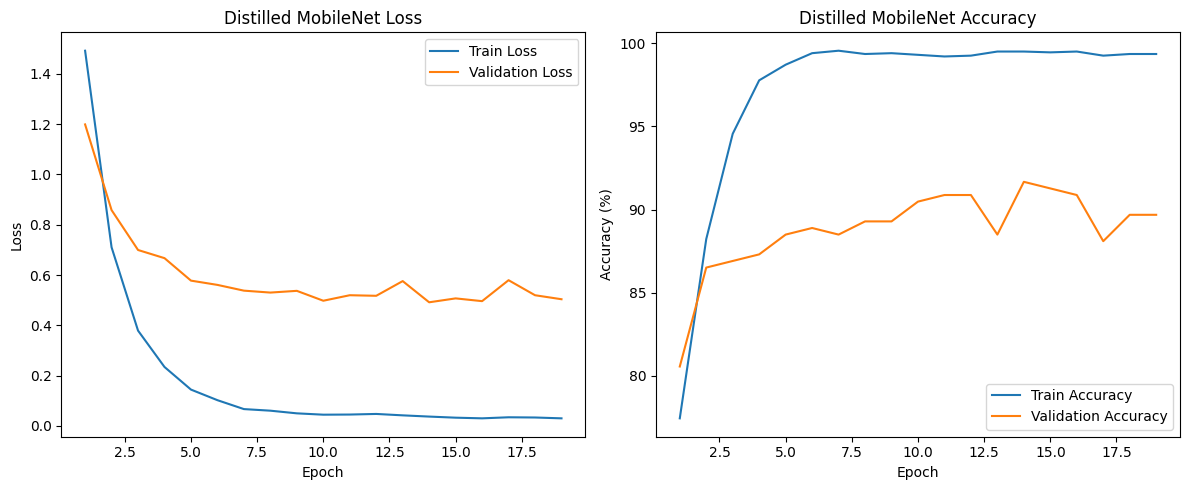

In [69]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Distilled MobileNet Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Distilled MobileNet Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      0.91      0.95        34
       glass       0.85      0.96      0.90        49
       metal       0.93      0.84      0.88        50
       paper       0.93      0.97      0.95        69
     plastic       1.00      0.95      0.97        39
       trash       0.86      0.92      0.89        13

    accuracy                           0.93       254
   macro avg       0.93      0.93      0.93       254
weighted avg       0.93      0.93      0.93       254

Confusion Matrix:
[[31  0  1  2  0  0]
 [ 0 47  1  1  0  0]
 [ 0  7 42  0  0  1]
 [ 0  0  1 67  0  1]
 [ 0  1  0  1 37  0]
 [ 0  0  0  1  0 12]]


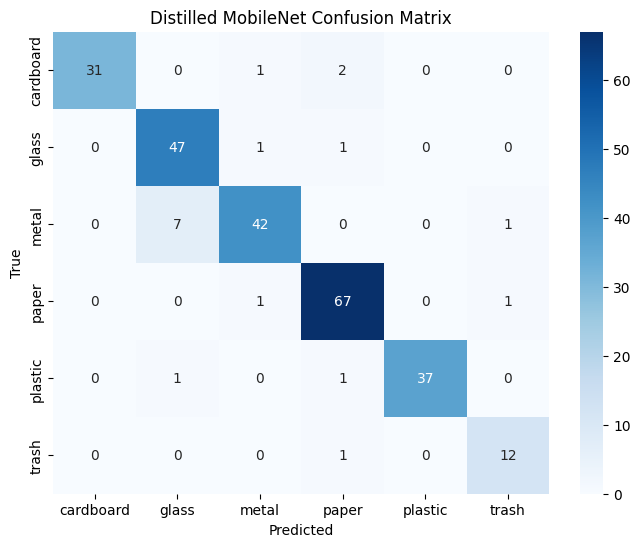

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import numpy as np

student.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Distilled MobileNet Confusion Matrix')
plt.show()


In [71]:
import json
with open("classes.json", "w") as f:
    json.dump(classes, f)


In [20]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 11.5 MB/s eta 0:00:00


In [21]:
import torch
from torchvision import models

student = models.mobilenet_v2(weights=None)
student.classifier[1] = torch.nn.Linear(student.classifier[1].in_features, len(classes))
student.load_state_dict(torch.load("best_mobilenet_distilled.pth"))
student.eval()

dummy = torch.randn(1, 3, 224, 224)
torch.onnx.export(student, dummy, "garbage.onnx",
                  input_names=["input"], output_names=["output"],
                  opset_version=15)


W1123 05:39:52.747000 1389 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 15 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

Applied 104 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,3,224,224]>
            ),
            outputs=(
                %"output"<FLOAT,[1,6]>
            ),
            initializers=(
                %"features.0.0.weight"<FLOAT,[32,3,3,3]>{Tensor(...)},
                %"features.1.conv.0.0.weight"<FLOAT,[32,1,3,3]>{Tensor(...)},
                %"features.1.conv.1.weight"<FLOAT,[16,32,1,1]>{Tensor(...)},
                %"features.2.conv.1.0.weight"<FLOAT,[96,1,3,3]>{Tensor(...)},
                %"classifier.1.bias"<FLOAT,[6]>{TorchTensor<FLOAT,[6]>(Parameter containing: tensor([-0.0055, -0.0038,  0.0092,  0.0164,  0.0002,  0.0220], requires_grad=True), name='classifier.1.bias')},
                %